In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
train_path = '/kaggle/input/teeth-ds/Teeth DataSet/Teeth_Dataset/Training'
valid_path = '/kaggle/input/teeth-ds/Teeth DataSet/Teeth_Dataset/Validation'
test_path = '/kaggle/input/teeth-ds/Teeth DataSet/Teeth_Dataset/Testing'

In [4]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

# in training> folder(class) 2 > image 5
example_image_path = os.path.join(train_path, os.listdir(train_path)[2], os.listdir(os.path.join(train_path, os.listdir(train_path)[2]))[5])

image = Image.open(example_image_path)
image_array = tf.keras.preprocessing.image.img_to_array(image)

print(f"Image size (width, height): {image.size}")
print(f"Image mode (color channels): {image.mode}")
print(f"Image shape: {image_array.shape}")

Image size (width, height): (256, 256)
Image mode (color channels): RGB
Image shape: (256, 256, 3)


In [5]:
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode='nearest'
)

datagen_valid = ImageDataGenerator(rescale=1.0/255) 


In [6]:
training = datagen.flow_from_directory(train_path, target_size=(224, 224),batch_size=32, class_mode='categorical', color_mode ='rgb')

validating = datagen_valid.flow_from_directory(valid_path, target_size=(224, 224),batch_size=32, class_mode='categorical', color_mode ='rgb')

testing = datagen_valid.flow_from_directory(test_path, target_size=(224, 224),batch_size=32, class_mode='categorical',  color_mode ='rgb', shuffle = False)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [7]:
for class_name, label in training.class_indices.items():
    print(f"Class: {class_name}, Label: {label}")

Class: CaS, Label: 0
Class: CoS, Label: 1
Class: Gum, Label: 2
Class: MC, Label: 3
Class: OC, Label: 4
Class: OLP, Label: 5
Class: OT, Label: 6


In [8]:
images, labels = next(training)
print(f"Image shape: {images[0].shape}")

Image shape: (224, 224, 3)


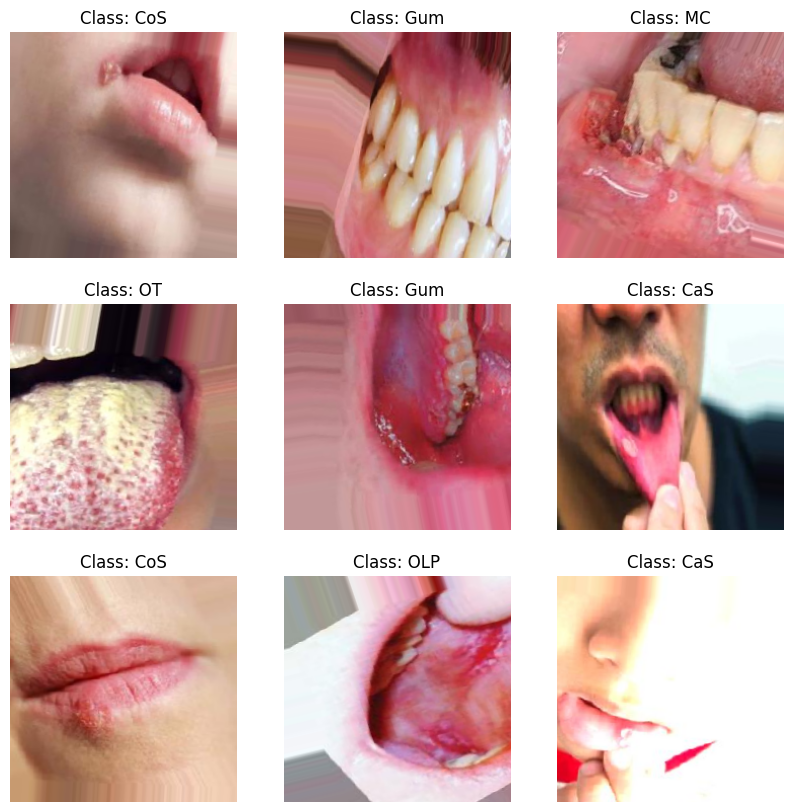

In [10]:
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(images[i])
  plt.title(f"Class: {list(training.class_indices.keys())[list(labels[i]).index(1)]}")
  plt.axis('off')
plt.show()


In [9]:
print(training.class_indices.keys())
print(training.class_indices.values())
print(training.class_indices.items())

dict_keys(['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT'])
dict_values([0, 1, 2, 3, 4, 5, 6])
dict_items([('CaS', 0), ('CoS', 1), ('Gum', 2), ('MC', 3), ('OC', 4), ('OLP', 5), ('OT', 6)])


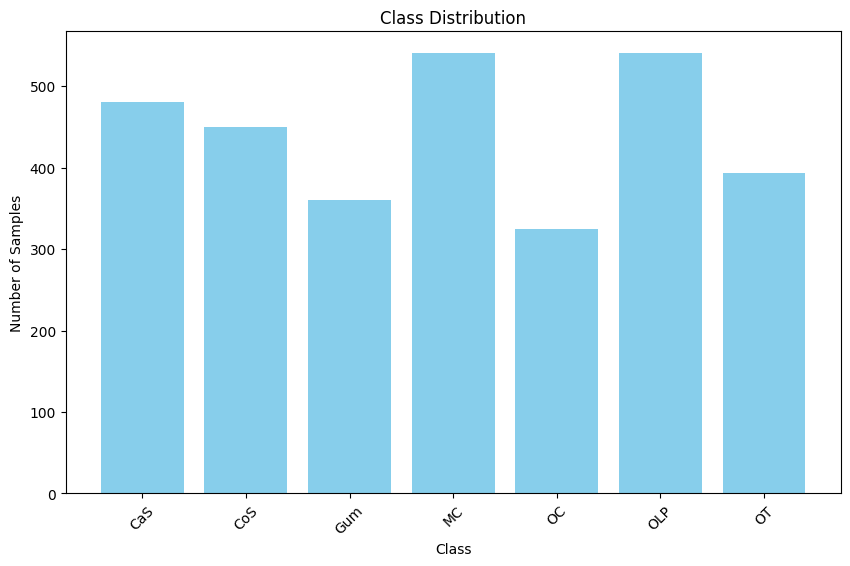

In [10]:
# get the count for sample per class
class_labels = list(training.class_indices.keys())
classes = training.classes
#loop for each class and count them
class_count = [list(classes).count(i) for i in range(len(class_labels))]
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_count, color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

In [11]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(training.classes),
    y= training.classes
)

class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: 0.91875, 1: 0.98, 2: 1.225, 3: 0.8166666666666667, 4: 1.3611111111111112, 5: 0.8166666666666667, 6: 1.1221374045801527}


In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',  
    save_best_only=True,
    mode='max', 
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=15, 
    mode='max',  
    verbose=1,
    restore_best_weights=True  
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',  
    factor=0.5,  
    patience=5,  
    min_lr=1e-6,  
    verbose=1
)


callbacks_list = [checkpoint, early_stopping, reduce_lr]

# Build The Model

In [13]:
input_shape = (224, 224, 3)
num_classes = len(training.class_indices)

In [14]:
training.num_classes

7

# mobileNet

In [80]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(training.num_classes, activation='softmax')
])

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


## RESNET

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def build_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    return model

model = build_model(input_shape, num_classes)


In [15]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

def build_vgg_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

model = build_vgg_model(input_shape, num_classes)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [81]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    training,
    validation_data=validating,
    epochs=100,
    class_weight=class_weights,
    callbacks = [callbacks_list]
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.1813 - loss: 2.0007
Epoch 1: val_accuracy improved from -inf to 0.32977, saving model to best_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 1163s 12s/step - accuracy: 0.1817 - loss: 1.9997 - val_accuracy: 0.3298 - val_loss: 1.6732 - learning_rate: 0.0010
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2999 - loss: 1.7120
Epoch 2: val_accuracy improved from 0.32977 to 0.42510, saving model to best_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 1161s 12s/step - accuracy: 0.3004 - loss: 1.7113 - val_accuracy: 0.4251 - val_loss: 1.4654 - learning_rate: 0.0010
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3855 - loss: 1.5440
Epoch 3: val_accuracy improved from 0.42510 to 0.46109, saving model to best_model.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 1160s 12s/step - accuracy: 0.3855 - loss: 1.5438 - val_accuracy: 0.4611 - val_loss: 1.3857 - learning_rate: 0.0010
Epoch 4/100
63/97 ━━━━━━━━━━━━━━━━━━━━ 5:04 9s/step - accuracy: 0.4367

In [57]:
test_loss, test_accuracy = model.evaluate(testing)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 699ms/step - accuracy: 0.9818 - loss: 0.0627
Test Accuracy: 97.37%


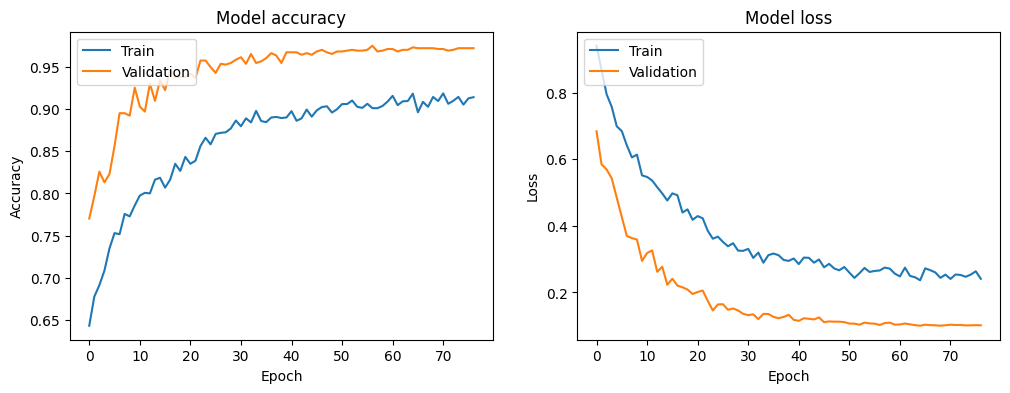

In [58]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 730ms/step


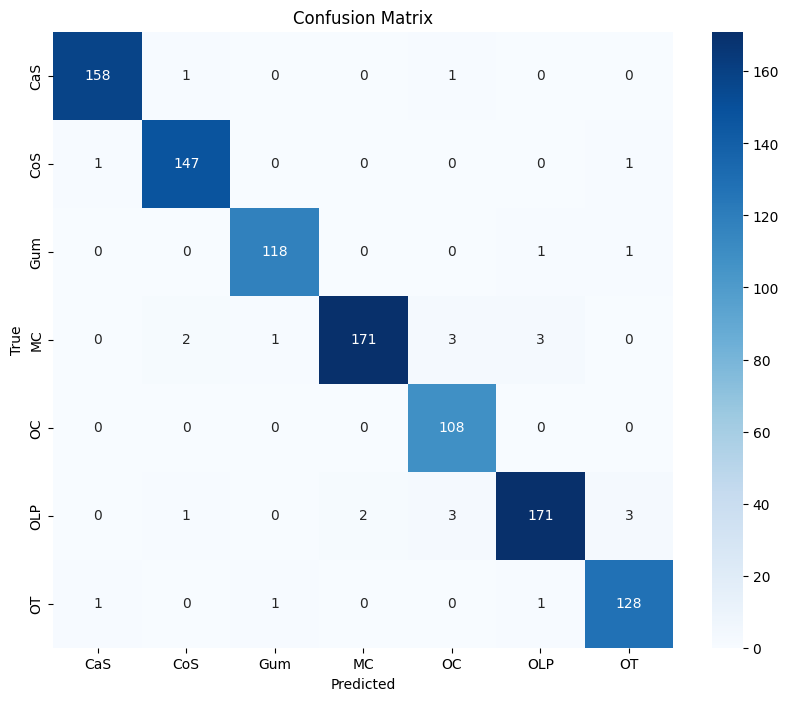

Classification Report:
              precision    recall  f1-score   support

         CaS       0.99      0.99      0.99       160
         CoS       0.97      0.99      0.98       149
         Gum       0.98      0.98      0.98       120
          MC       0.99      0.95      0.97       180
          OC       0.94      1.00      0.97       108
         OLP       0.97      0.95      0.96       180
          OT       0.96      0.98      0.97       131

    accuracy                           0.97      1028
   macro avg       0.97      0.98      0.97      1028
weighted avg       0.97      0.97      0.97      1028



In [64]:
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns

y_true = testing.classes

# Make predictions
y_pred = model.predict(testing)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get class names
class_names = list(testing.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# print classification report
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(report)